Weather Forecasting: Comparing Linear, Ridge, and Lasso Regression

Downloaded: weather_data.csv

Loading data...
Dataset shape: (3654, 165)

Preprocessing...
Target: BASEL_temp_mean
Features: 8
Samples: 3654

Splitting data (80-20)...
Train: 2923 | Test: 731

Training Simple Linear Regression...
Train RMSE: 0.5534 | Test RMSE: 0.5205
Train R2: 0.9945 | Test R2: 0.9950

Training Ridge Regression...
Best alpha: 0.1
Train RMSE: 0.5534 | Test RMSE: 0.5206
Train R2: 0.9945 | Test R2: 0.9950

Training Lasso Regression...
Best alpha: 0.001
Features selected: 8/8
Train RMSE: 0.5535 | Test RMSE: 0.5207
Train R2: 0.9945 | Test R2: 0.9950

Model Comparison
        Model  Train RMSE  Test RMSE  Train R2  Test R2  CV RMSE
Simple Linear    0.553444   0.520540  0.994452 0.994978 0.555845
        Ridge    0.553445   0.520558  0.994452 0.994978 0.555845
        Lasso    0.553457   0.520679  0.994452 0.994975 0.555805

Best model: Simple Linear
Test RMSE: 0.5205
Test R2: 0.9950

Generating visualizatio

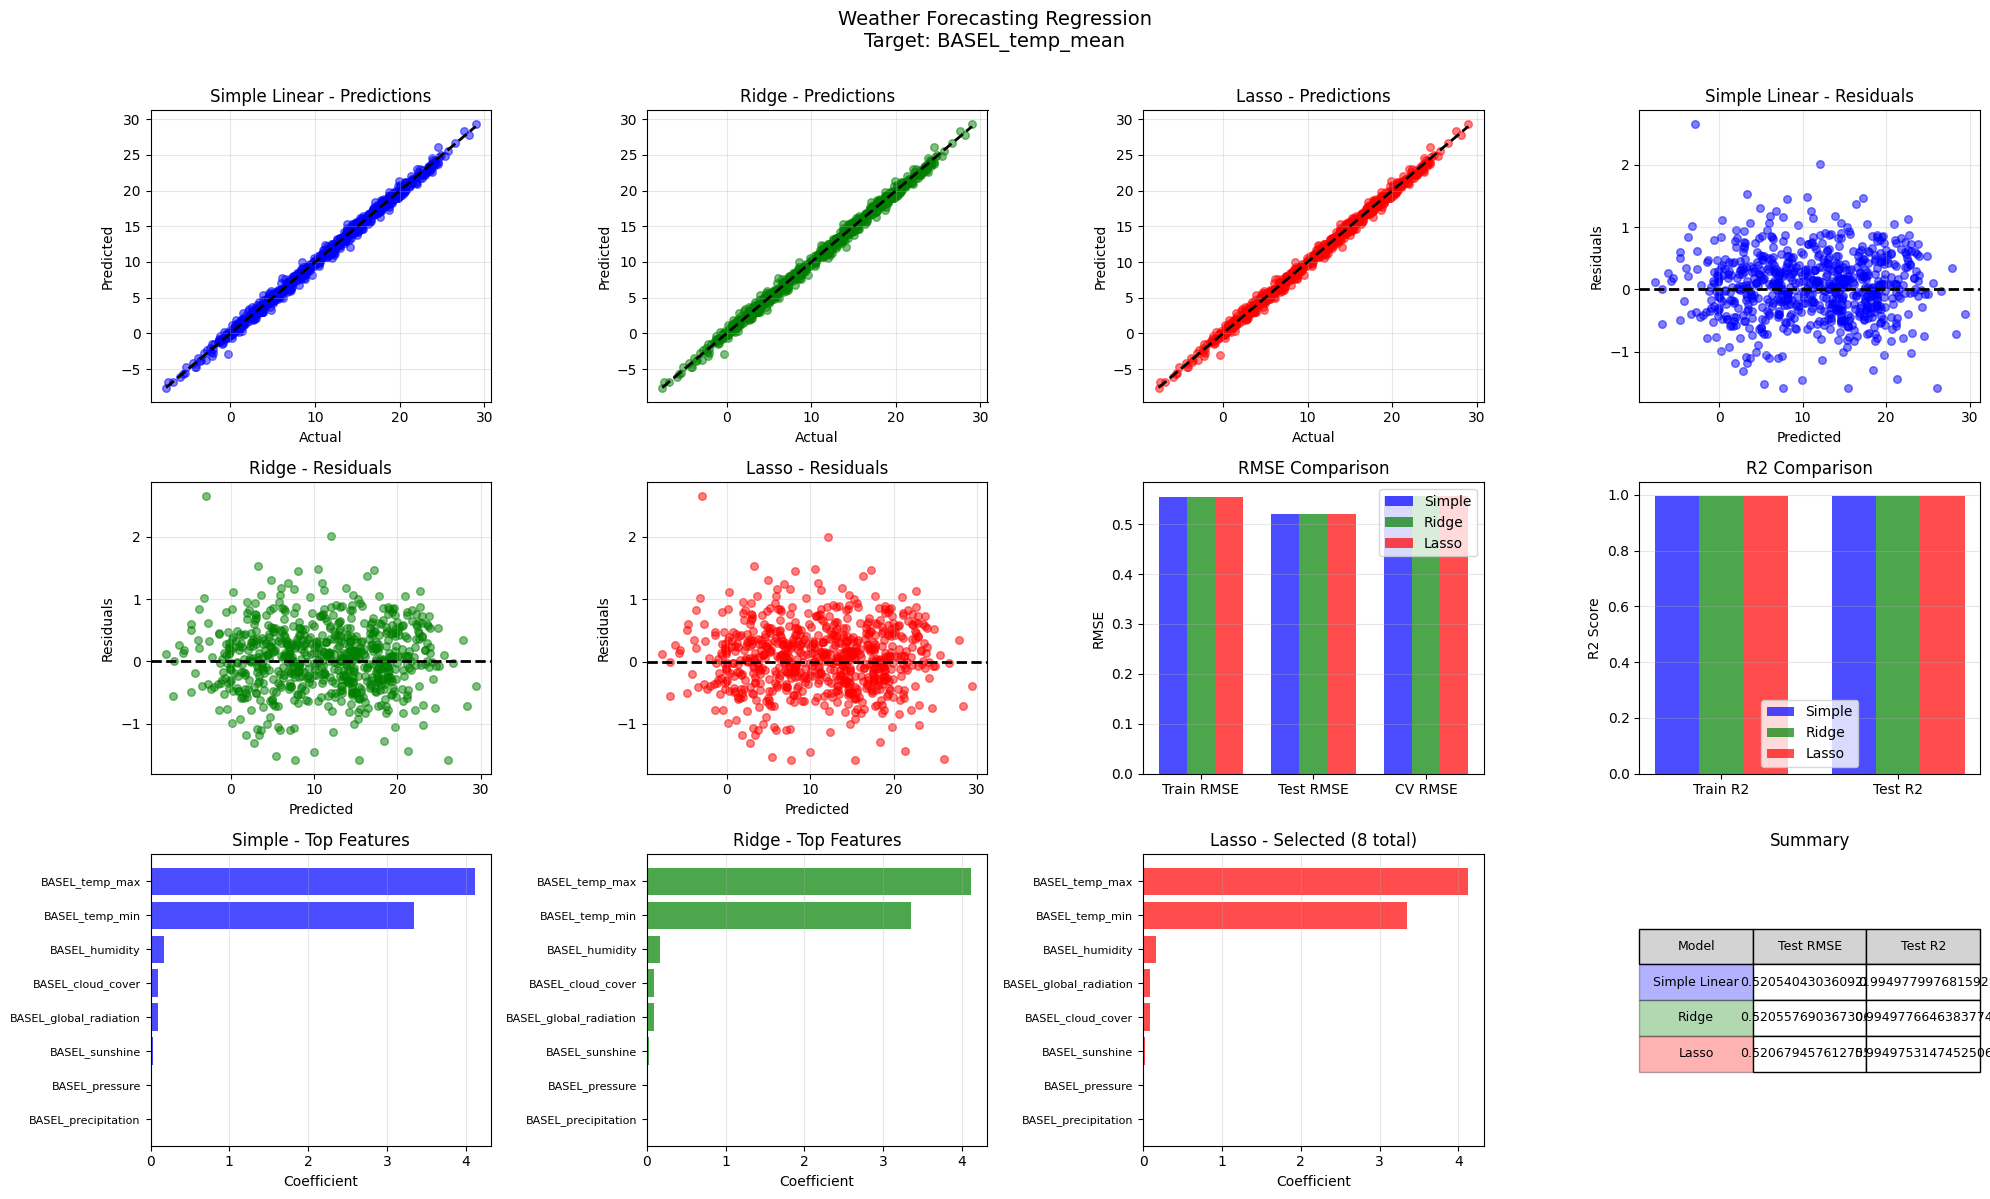


Done. Results saved.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
import urllib.request
import os

warnings.filterwarnings('ignore')

print("Weather Forecasting: Comparing Linear, Ridge, and Lasso Regression\n")

def download_weather_dataset():
    print("Downloading dataset...")
    url = "https://zenodo.org/records/7525955/files/weather_prediction_dataset.csv"
    filename = "weather_data.csv"

    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url, filename)
            print(f"Downloaded: {filename}")
        except:
            print("Download failed, generating sample data...")
            create_sample_dataset()
            filename = "weather_sample.csv"
    else:
        print(f"Using existing: {filename}")

    return filename

def create_sample_dataset():
    np.random.seed(42)
    n = 1000
    dates = pd.date_range(start='2020-01-01', periods=n, freq='D')

    temp_mean = 15 + 10 * np.sin(np.arange(n) * 2 * np.pi / 365) + np.random.randn(n) * 3
    humidity = 60 + np.random.randn(n) * 15
    pressure = 1013 + np.random.randn(n) * 10
    wind_speed = 5 + np.random.randn(n) * 2
    cloud_cover = np.random.randint(0, 9, n)
    precipitation = np.maximum(0, np.random.randn(n) * 2 + 1)
    temp_max = temp_mean + np.random.uniform(2, 8, n)
    temp_min = temp_mean - np.random.uniform(2, 8, n)

    df = pd.DataFrame({
        'date': dates,
        'Basel_temp_mean': temp_mean,
        'Basel_temp_max': temp_max,
        'Basel_temp_min': temp_min,
        'Basel_humidity': humidity,
        'Basel_pressure': pressure,
        'Basel_wind_speed': wind_speed,
        'Basel_cloud_cover': cloud_cover,
        'Basel_precipitation': precipitation
    })

    df.to_csv('weather_sample.csv', index=False)
    print("Sample dataset created")

def load_and_explore_data(filename):
    print("\nLoading data...")
    df = pd.read_csv(filename)
    print(f"Dataset shape: {df.shape}")
    return df

def preprocess_data(df):
    print("\nPreprocessing...")

    temp_cols = [col for col in df.columns if '_temp_mean' in col]

    if len(temp_cols) == 0:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if 'date' in df.columns:
            df = df.drop('date', axis=1)

        if len(numeric_cols) > 1:
            target_col = numeric_cols[0]
            feature_cols = numeric_cols[1:]
        else:
            print("Error: Not enough numeric columns")
            return None, None, None, None
    else:
        city = temp_cols[0].replace('_temp_mean', '')
        feature_cols = [col for col in df.columns if city in col and '_temp_mean' not in col]
        target_col = f'{city}_temp_mean'
        feature_cols = [col for col in feature_cols if df[col].dtype in ['float64', 'int64']]

    df_clean = df[[target_col] + feature_cols].copy().dropna()

    print(f"Target: {target_col}")
    print(f"Features: {len(feature_cols)}")
    print(f"Samples: {df_clean.shape[0]}")

    if df_clean.shape[0] < 100:
        print("Dataset too small, generating sample...")
        create_sample_dataset()
        df = pd.read_csv('weather_sample.csv')
        return preprocess_data(df)

    X = df_clean[feature_cols]
    y = df_clean[target_col]

    return X, y, feature_cols, target_col

def split_and_scale_data(X, y):
    print("\nSplitting data (80-20)...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def train_simple_regression(X_train, y_train, X_test, y_test):
    print("\nTraining Simple Linear Regression...")

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"Train R2: {train_r2:.4f} | Test R2: {test_r2:.4f}")

    return {
        'model': model,
        'name': 'Simple Linear',
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

def train_ridge_regression(X_train, y_train, X_test, y_test):
    print("\nTraining Ridge Regression...")

    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    ridge = Ridge()
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    model = grid_search.best_estimator_
    best_alpha = grid_search.best_params_['alpha']

    print(f"Best alpha: {best_alpha}")

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"Train R2: {train_r2:.4f} | Test R2: {test_r2:.4f}")

    return {
        'model': model,
        'name': 'Ridge',
        'best_alpha': best_alpha,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

def train_lasso_regression(X_train, y_train, X_test, y_test):
    print("\nTraining Lasso Regression...")

    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    lasso = Lasso(max_iter=10000)
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    model = grid_search.best_estimator_
    best_alpha = grid_search.best_params_['alpha']
    n_features_used = np.sum(model.coef_ != 0)

    print(f"Best alpha: {best_alpha}")
    print(f"Features selected: {n_features_used}/{len(model.coef_)}")

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"Train R2: {train_r2:.4f} | Test R2: {test_r2:.4f}")

    return {
        'model': model,
        'name': 'Lasso',
        'best_alpha': best_alpha,
        'n_features_used': n_features_used,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

def compare_models(simple_results, ridge_results, lasso_results):
    print("\n" + "="*70)
    print("Model Comparison")
    print("="*70)

    comparison_df = pd.DataFrame({
        'Model': [simple_results['name'], ridge_results['name'], lasso_results['name']],
        'Train RMSE': [simple_results['train_rmse'], ridge_results['train_rmse'], lasso_results['train_rmse']],
        'Test RMSE': [simple_results['test_rmse'], ridge_results['test_rmse'], lasso_results['test_rmse']],
        'Train R2': [simple_results['train_r2'], ridge_results['train_r2'], lasso_results['train_r2']],
        'Test R2': [simple_results['test_r2'], ridge_results['test_r2'], lasso_results['test_r2']],
        'CV RMSE': [simple_results['cv_rmse'], ridge_results['cv_rmse'], lasso_results['cv_rmse']]
    })

    print(comparison_df.to_string(index=False))

    best_idx = comparison_df['Test RMSE'].idxmin()
    print(f"\nBest model: {comparison_df.loc[best_idx, 'Model']}")
    print(f"Test RMSE: {comparison_df.loc[best_idx, 'Test RMSE']:.4f}")
    print(f"Test R2: {comparison_df.loc[best_idx, 'Test R2']:.4f}")
    print("="*70)

    return comparison_df

def visualize_results(simple_results, ridge_results, lasso_results, y_train, y_test,
                     comparison_df, feature_cols, target_col):
    print("\nGenerating visualizations...")

    fig = plt.figure(figsize=(20, 12))

    models_data = [
        ('Simple Linear', simple_results, 'blue'),
        ('Ridge', ridge_results, 'green'),
        ('Lasso', lasso_results, 'red')
    ]

    for idx, (name, results, color) in enumerate(models_data, 1):
        ax = plt.subplot(3, 4, idx)
        plt.scatter(y_test, results['y_test_pred'], alpha=0.5, color=color, s=30)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'{name} - Predictions')
        plt.grid(True, alpha=0.3)

    for idx, (name, results, color) in enumerate(models_data, 4):
        ax = plt.subplot(3, 4, idx)
        residuals = y_test.values - results['y_test_pred']
        plt.scatter(results['y_test_pred'], residuals, alpha=0.5, color=color, s=30)
        plt.axhline(y=0, color='k', linestyle='--', lw=2)
        plt.xlabel('Predicted')
        plt.ylabel('Residuals')
        plt.title(f'{name} - Residuals')
        plt.grid(True, alpha=0.3)

    ax = plt.subplot(3, 4, 7)
    metrics = ['Train RMSE', 'Test RMSE', 'CV RMSE']
    x = np.arange(len(metrics))
    width = 0.25

    plt.bar(x - width, [simple_results['train_rmse'], simple_results['test_rmse'], simple_results['cv_rmse']],
            width, label='Simple', color='blue', alpha=0.7)
    plt.bar(x, [ridge_results['train_rmse'], ridge_results['test_rmse'], ridge_results['cv_rmse']],
            width, label='Ridge', color='green', alpha=0.7)
    plt.bar(x + width, [lasso_results['train_rmse'], lasso_results['test_rmse'], lasso_results['cv_rmse']],
            width, label='Lasso', color='red', alpha=0.7)

    plt.ylabel('RMSE')
    plt.title('RMSE Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    ax = plt.subplot(3, 4, 8)
    metrics = ['Train R2', 'Test R2']
    x = np.arange(len(metrics))

    plt.bar(x - width, [simple_results['train_r2'], simple_results['test_r2']],
            width, label='Simple', color='blue', alpha=0.7)
    plt.bar(x, [ridge_results['train_r2'], ridge_results['test_r2']],
            width, label='Ridge', color='green', alpha=0.7)
    plt.bar(x + width, [lasso_results['train_r2'], lasso_results['test_r2']],
            width, label='Lasso', color='red', alpha=0.7)

    plt.ylabel('R2 Score')
    plt.title('R2 Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    ax = plt.subplot(3, 4, 9)
    importance = np.abs(simple_results['model'].coef_)
    sorted_idx = np.argsort(importance)[-10:]
    features = [feature_cols[i] if i < len(feature_cols) else f'F{i}' for i in sorted_idx]
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], color='blue', alpha=0.7)
    plt.yticks(range(len(sorted_idx)), features, fontsize=8)
    plt.xlabel('Coefficient')
    plt.title('Simple - Top Features')
    plt.grid(True, alpha=0.3, axis='x')

    ax = plt.subplot(3, 4, 10)
    importance = np.abs(ridge_results['model'].coef_)
    sorted_idx = np.argsort(importance)[-10:]
    features = [feature_cols[i] if i < len(feature_cols) else f'F{i}' for i in sorted_idx]
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], color='green', alpha=0.7)
    plt.yticks(range(len(sorted_idx)), features, fontsize=8)
    plt.xlabel('Coefficient')
    plt.title('Ridge - Top Features')
    plt.grid(True, alpha=0.3, axis='x')

    ax = plt.subplot(3, 4, 11)
    importance = np.abs(lasso_results['model'].coef_)
    non_zero_idx = np.where(importance > 0)[0]

    if len(non_zero_idx) > 0:
        sorted_idx = non_zero_idx[np.argsort(importance[non_zero_idx])[-10:]]
        features = [feature_cols[i] if i < len(feature_cols) else f'F{i}' for i in sorted_idx]
        plt.barh(range(len(sorted_idx)), importance[sorted_idx], color='red', alpha=0.7)
        plt.yticks(range(len(sorted_idx)), features, fontsize=8)
        plt.xlabel('Coefficient')
        plt.title(f'Lasso - Selected ({len(non_zero_idx)} total)')
        plt.grid(True, alpha=0.3, axis='x')
    else:
        plt.text(0.5, 0.5, 'No features selected', ha='center', va='center')
        plt.title('Lasso - Features')

    ax = plt.subplot(3, 4, 12)
    comparison_data = comparison_df[['Model', 'Test RMSE', 'Test R2']]
    colors_map = {'Simple Linear': 'blue', 'Ridge': 'green', 'Lasso': 'red'}
    colors = [colors_map[model] for model in comparison_data['Model']]

    table = plt.table(cellText=comparison_data.values, colLabels=comparison_data.columns,
                     cellLoc='center', loc='center', colColours=['lightgray']*3)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    for i in range(len(comparison_data)):
        table[(i+1, 0)].set_facecolor(colors[i])
        table[(i+1, 0)].set_alpha(0.3)

    plt.axis('off')
    plt.title('Summary')

    plt.suptitle(f'Weather Forecasting Regression\nTarget: {target_col}', fontsize=14, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])

    output_file = 'weather_results.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved: {output_file}")

    plt.show()

def main():
    filename = download_weather_dataset()
    df = load_and_explore_data(filename)
    X, y, feature_cols, target_col = preprocess_data(df)

    if X is None:
        print("Preprocessing failed")
        return

    X_train, X_test, y_train, y_test, scaler = split_and_scale_data(X, y)

    simple_results = train_simple_regression(X_train, y_train, X_test, y_test)
    ridge_results = train_ridge_regression(X_train, y_train, X_test, y_test)
    lasso_results = train_lasso_regression(X_train, y_train, X_test, y_test)

    comparison_df = compare_models(simple_results, ridge_results, lasso_results)

    visualize_results(simple_results, ridge_results, lasso_results, y_train, y_test,
                     comparison_df, feature_cols, target_col)

    comparison_df.to_csv('model_comparison.csv', index=False)
    print("\nDone. Results saved.")

if __name__ == "__main__":
    main()
